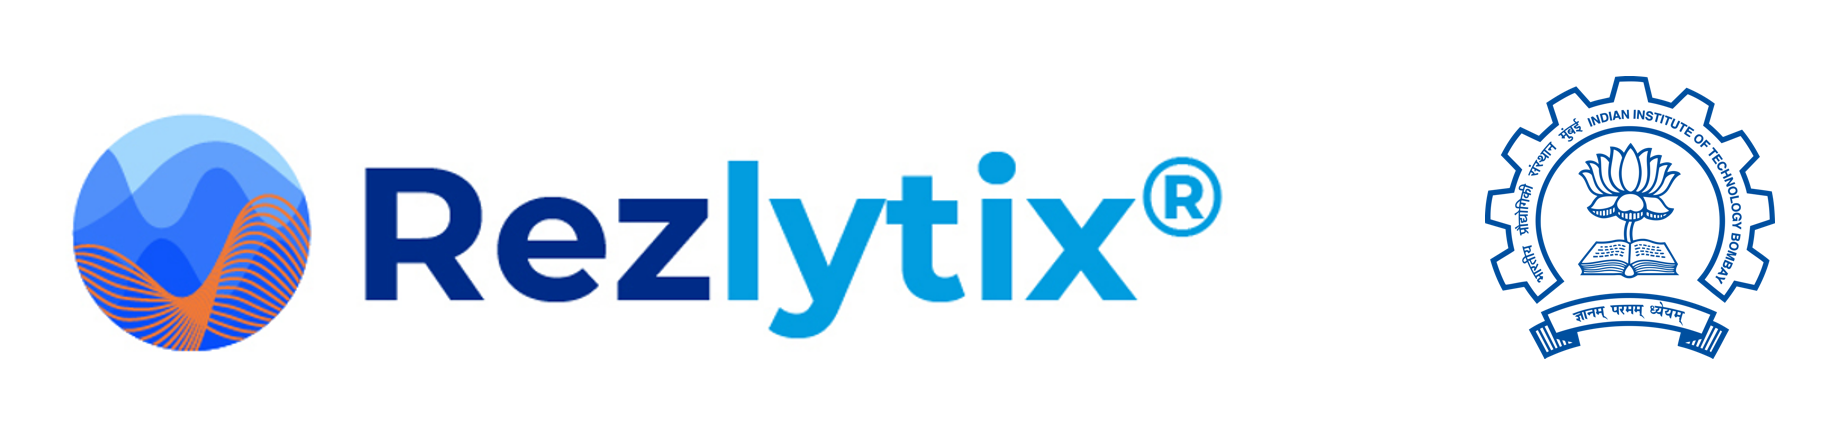

## Notebook overview

* Using ML to impute missing log data 




# **setup**

-----

In [2]:
##### Applicable only if you are running this notebook on Colab. Disble otherwise.
##### Mount your google drive to this notebook. It will require some permissions.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define base working directory for this session. Same as the one created earlier.
import os
# base_dir = "/content/drive/My Drive/<Your_folder_name>"     # Please change path / folder name as required. 
base_dir ="/content/drive/MyDrive/Colab Notebooks/workshop_data"
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

if not os.path.isdir(base_dir + "/loaded"):
    os.mkdir(base_dir + "/loaded")

os.chdir(base_dir)

**Please ensure that the sample data folder (workshop_data) that we have provided is inside this base directory.**

### Required libraries

Let's first get all the required libraries.
Since some of these have fairly specific / limited usage, they are usually not part of the standard set of libraries already installed within Colab.

In [4]:
# Imports for JupyterLite
%pip install -q ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


In [5]:
# Let's first install a few uncommon libraries to this environment.
!pip install lasio
!pip install wget
!pip install segyio
!pip install segysak
!pip install pydantic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=a50e6c8f9d987fd0b9926422d4adcc852ab3de1eb67f31c30c6594c1ee1fedc6
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 KB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.

Other common libraries you will need in this notebook. Please install them if you don't already have them. These come pre-installed in Colab.

* numpy
* scipy
* pandas
* matplotlib
* seaborn
* plotly

In [6]:
# Scientific and data analysis libraries

import pandas as pd
import numpy as np
import numpy.linalg as LA
from numpy.polynomial.polynomial import polyfit
import xarray as xr
import math
from math import sqrt

import scipy
from scipy import interpolate as interp
from scipy.interpolate import CloughTocher2DInterpolator, griddata
from scipy import signal
from scipy.signal import savgol_filter, correlate, coherence, hilbert, periodogram, welch, butter, lfilter
from scipy.spatial import KDTree, cKDTree, distance
from scipy.fftpack import ifft,fftshift,fft
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from functools import reduce

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
from matplotlib import gridspec
from matplotlib.pyplot import cm
from matplotlib.cbook import flatten
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipyw

# Typesafe coding
from pydantic import BaseModel, Field
from typing import Any, Optional,List, Union
from typing import Dict, Union
from typing_extensions import Annotated, Literal

# Generic libraries
import os
import time
import shutil
from shutil import copyfile
import warnings

warnings.filterwarnings("ignore")

mpl.rc('font', size=20)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format

# Use if you want to remove limits on the max no. of rows visible in a dataframe
# pd.set_option('display.max_rows', None)

# **now**

# **ML applied: Prediction of sonic logs**

### The Problem Statement


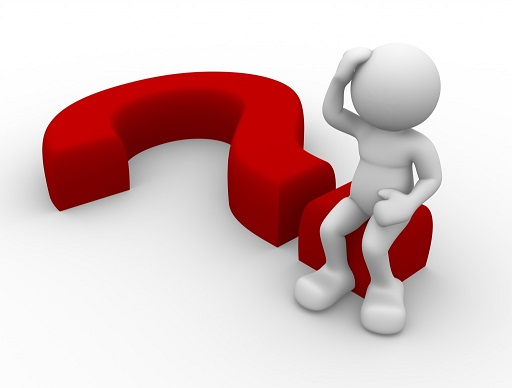

There are several instances when both Compressional sonic (DTC) and shear sonic (DTS) logs are not acquired simultaneously, due to financial constraints, lack of equipment, etc. <br>It may also so happen that the logs are missing for a certain depth range.

Under such circumstances, machine learning techniques can be effectively used to predict DTC and DTS logs to improve subsurface characterization.<br><br>

The goal of this exercise is to develop data-driven models by processing “easy-to-acquire” conventional logs from wells and use the models to predict synthetic compressional and shear travel-time logs.

**ML workflow life-cycle**

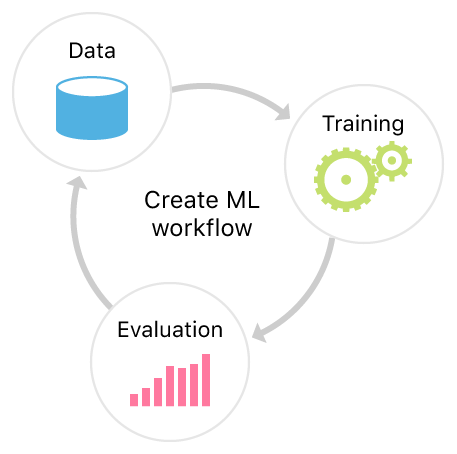


### Step 1. Load and Display the Well-log Datasets - TBU

* We had already created Xarrays from the LAS files during our "Data Loading" exercise. Let's load back these files and create dataframes from them.<br><br>
* To make things easier, we have chosen 4 wells for this exercise to analyze:<br> 
    * '15_9-F-11A'
    * '15_9-F-1A'
    * '15_9-F-1B'
    * '15_9-F-11T2'

In [7]:
def well_log_plot(well_df=None, logs=None,well_name=None):
  z=len(logs)+1

  fig,ax=plt.subplots(figsize=(40,40))

  count = 0
  depth = well_df.index

  for log in logs:

      if log=='CALI':
          count+=1
          ax1=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1)
          
          ax1.plot(well_df[log], depth, color = "red", linewidth = 0.5)
        
          ax1.set_xlabel("Cali")  
          ax1.set_ylabel("Depth (m)")      
          ax1.xaxis.label.set_color("red")
          ax1.set_xlim(5,10)

          ax1.tick_params(axis='x', colors="red")
        
          ax1.set_xticks([5,10])
          ax1.grid(which='major', color='lightgrey', linestyle='-')
        
          ax1.xaxis.set_ticks_position("top")
          ax1.xaxis.set_label_position("top")
        
          ax1.spines["top"].set_position(("axes", 1.02))
          ax1.spines["top"].set_edgecolor("red")

  for log in logs:    
      if log=='GR':
          count+=1
          ax2=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1, sharey = ax1)

          curve=well_df[log]

          left_col_value = curve.min()
          right_col_value = curve.max()

          span = abs(left_col_value - right_col_value)

          ##assigning a color map
          cmap = plt.get_cmap('nipy_spectral')  

          ##create array of values to divide up the area under curve
          color_index = np.arange(0, 300, span / 100)

          ax2.plot(curve, depth, color = "black", linewidth = 0.5)

          for index in sorted(color_index):
              index_value = (index - left_col_value)/span
              color = cmap(index_value) #obtain colour for color index value
              ax2.fill_betweenx( depth, 0 , curve, where = curve >= index,  color = color)


          ax2.set_xlabel("GR")
          ax2.xaxis.label.set_color("green")
          ax2.set_xlim(0, 300)        

          ax2.tick_params(axis='x', colors="green") 

          ax2.title.set_color('green')
          ax2.set_xticks([0, 100, 200, 300])
          ax2.grid(which='major', color='lightgrey', linestyle='-')  

          ax2.xaxis.set_ticks_position("top")
          ax2.xaxis.set_label_position("top")        

          ax2.spines["top"].set_position(("axes", 1.02))
          ax2.spines["top"].set_edgecolor("green")

  for log in logs:    
      if log=='RT':
          count+=1
          ax3=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax3.plot(well_df[log], depth, color = "blue", linewidth = 0.5)
        
          ax3.set_xlabel("Resistivity")
          ax3.xaxis.label.set_color("blue")
          ax3.set_xlim(0.1, 1000)
        
          ax3.tick_params(axis='x', colors="blue")
        
          ax3.semilogx()

          ax3.set_xticks([0.1, 1, 10, 100, 1000])
          ax3.grid(which='major', color='lightgrey', linestyle='-')
        
          ax3.xaxis.set_ticks_position("top")
          ax3.xaxis.set_label_position("top")
        
          ax3.spines["top"].set_position(("axes", 1.02))
          ax3.spines["top"].set_edgecolor("blue")

  for log in logs:    
      if log=='RHOB':
          count+=1
          ax4=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax4.plot(well_df[log], depth, color = "red", linewidth = 0.5)
        
          ax4.set_xlabel("Density")        
          ax4.xaxis.label.set_color("red")
          ax4.set_xlim(1.5,3)

          ax4.tick_params(axis='x', colors="red")
        
          ax4.set_xticks([1.5,2,3])
          ax4.grid(which='major', color='lightgrey', linestyle='-')
        
          ax4.xaxis.set_ticks_position("top")
          ax4.xaxis.set_label_position("top")
        
          ax4.spines["top"].set_position(("axes", 1.02))
          ax4.spines["top"].set_edgecolor("red")

  for log in logs:    
      if log=='NPHI':
          count+=1
          ax5=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax5.plot(well_df[log], depth, color = "blue", linewidth = 0.5)
        
          ax5.set_xlabel('NPHI')
          ax5.xaxis.label.set_color("blue")
          ax5.set_xlim(1,0)
        
          ax5.tick_params(axis='x', colors="blue")
        
          ax5.set_xticks([1,0.5,0])
          ax5.grid(which='major', color='lightgrey', linestyle='-')
        
          ax5.xaxis.set_ticks_position("top")
          ax5.xaxis.set_label_position("top")

          ax5.spines["top"].set_position(("axes", 1.02))
          ax5.spines["top"].set_edgecolor("blue")

  for log in logs:    
      if log=='PEF':
          count+=1
          ax6=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax6.plot(well_df[log], depth, color = "pink", linewidth = 0.5)
        
          ax6.set_xlabel("PEF")        
          ax6.xaxis.label.set_color("pink")
          ax6.set_xlim(0,10)

          ax6.tick_params(axis='x', colors="pink")
        
          ax6.set_xticks([0,10])
          ax6.grid(which='major', color='lightgrey', linestyle='-')
        
          ax6.xaxis.set_ticks_position("top")
          ax6.xaxis.set_label_position("top")
        
          ax6.spines["top"].set_position(("axes", 1.02))
          ax6.spines["top"].set_edgecolor("pink")

  for log in logs:    
      if log=='DT':
          count+=1
          ax7=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax7.plot(well_df[log], depth, color = "indigo", linewidth = 0.5)
        
          ax7.set_xlabel("DT")        
          ax7.xaxis.label.set_color("indigo")
          ax7.set_xlim(140,40)

          ax7.tick_params(axis='x', colors="indigo")
        
          ax7.set_xticks([140,40])
          ax7.grid(which='major', color='lightgrey', linestyle='-')
        
          ax7.xaxis.set_ticks_position("top")
          ax7.xaxis.set_label_position("top")
        
          ax7.spines["top"].set_position(("axes", 1.02))
          ax7.spines["top"].set_edgecolor("indigo")

  for log in logs:    
      if log=='DTS':
          count+=1
          ax8=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
        
          ax8.plot(well_df[log], depth, color = "cyan", linewidth = 0.5)
        
          ax8.set_xlabel("DTS")        
          ax8.xaxis.label.set_color("cyan")
          ax8.set_xlim(240,90)

          ax8.tick_params(axis='x', colors="cyan")
        
          ax8.set_xticks([240,90])
          ax8.grid(which='major', color='lightgrey', linestyle='-')
          
          ax8.xaxis.set_ticks_position("top")
          ax8.xaxis.set_label_position("top")
        
          ax8.spines["top"].set_position(("axes", 1.02))
          ax8.spines["top"].set_edgecolor("cyan")

  for ax in [ax1, ax2, ax2, ax4, ax5, ax6, ax7, ax8]:
      ax.set_ylim(depth.max(),depth.min())
    
  for ax in [ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
      plt.setp(ax.get_yticklabels(), visible = False)

  plt.tight_layout()
  fig.subplots_adjust(wspace = 0.15)
  plt.suptitle(f'{well_name}',y=1.02001,fontsize='large',backgroundcolor='lavender',fontweight='bold')
  plt.show()


In [8]:
def well_log_plot(well,logs,colors):
  # create the subplots; ncols equals the number of logs
  fig, ax = plt.subplots(nrows=1, ncols=len(logs),sharey=True, figsize=(20,10))
  # looping each log to display in the subplots
  for i in range(len(logs)):
    if i == 3:
      # for resistivity, semilog plot
      ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
    else:
      # for non-resistivity, normal plot
      ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
    ax[i].set_title(logs[i])
    ax[i].grid(True)

  plt.show()

*TBU - Change above function with well_log visualization function from Data Loading exercise*

In [9]:
def load_las_xr_to_df(well_name: str, 
                      las_xr_dir: str):
    """
        Function to load well xarrays to a dataframe

        Args:
            well_name (str): the name of the well
            las_xr_dir (str): the location of the xarray files

        Returns:
            dataframe: the well data.
    """
    xr_list = os.listdir(las_xr_dir)                                    # Creating a list of all available xarray files
    file_to_load = [file for file in xr_list if well_name in file]      # Identify the file for the current well

    well_xr = xr.open_dataset(las_xr_dir + file_to_load[0])
    well_df = well_xr.to_dataframe()
    well_df.reset_index(inplace=True)
    return well_df


In [10]:
wells_list  = ['15_9-F-11A',  '15_9-F-1A', '15_9-F-1B',  '15_9-F-11T2']
las_xr_dir = base_dir + '/loaded/'

wells = {}
for i in range(len(wells_list)):
    wells[i] = load_las_xr_to_df(well_name = wells_list[i], 
                                 las_xr_dir = las_xr_dir)

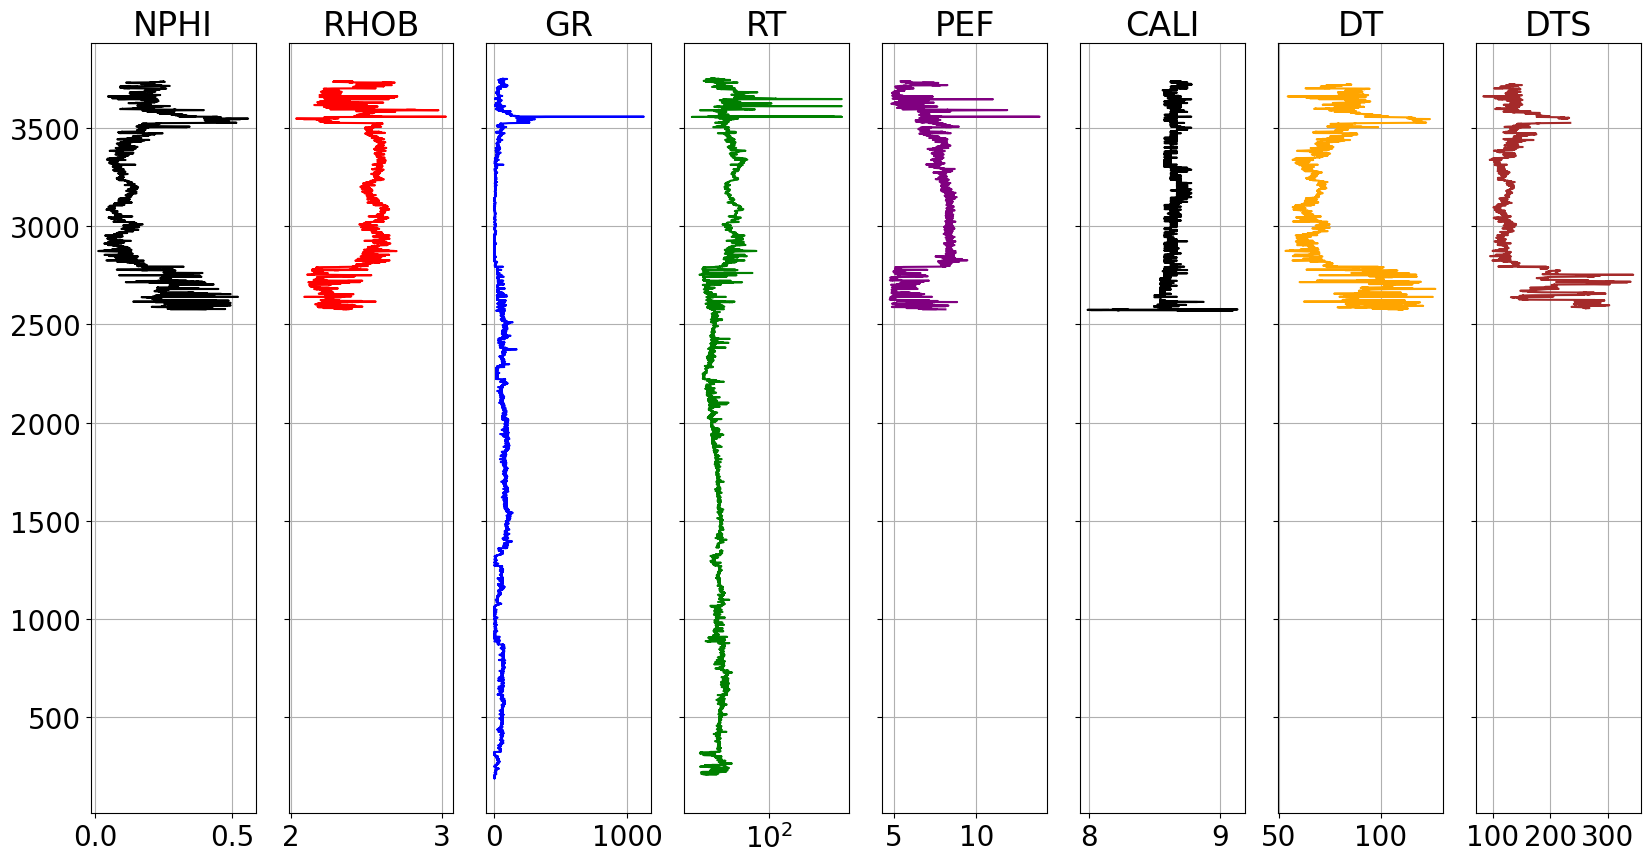

In [11]:
# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange','brown']
well_log_plot(wells[0],logs,colors)

-----

### Step 2. Data Preparation

* For all supervised ML algorithms, we need to split the data into training and test sets. In some cases, there is also a blind validation set which is completely unseen by the model.

* The training of the model is strictly performed on the training dataset.

* We want our model to be 
    * Robust
    * Generalizable
    * Accurate in its predictions

* We do not want our model to 
    * Overfit the training data
    * Unable to identify the general trend

* It is an under-appreciated fact that the quality of your model is a direct result of how good your data is.<br><br>

**Remember: Bad data will produce a bad model!**

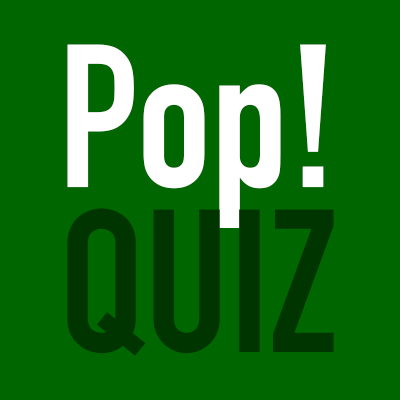

#### Pop Quiz

1.   **What is overfitting?**
2.   **How can we avoid it?**

* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 

















Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.
Overfitting occurs when the model performs well on training data but generalizes poorly to unseen data. 



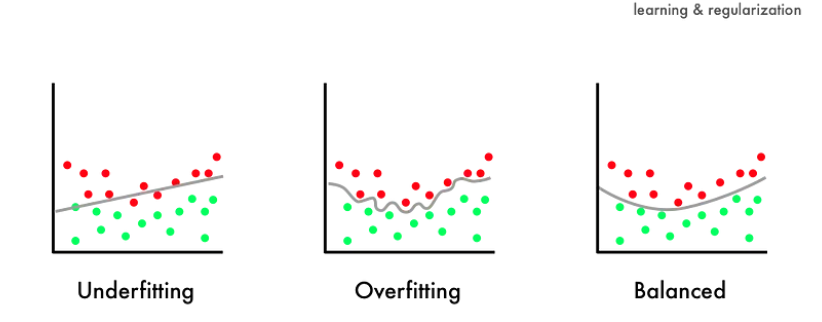


* Prevent Overfitting
1. Hold-out
2. Cross-validation
3. Data augmentation
4. Feature selection
5. Remove layers /number of units perlayer
6. Dropout
7. Early stopping




But first, let's define some helper functions which will be useful in our workflow.

In [12]:
def rolling_window(curve, window_length, func1d, step=1, return_rolled=False):
        """
        Helper function. Smoother for other smoothing/conditioning functions.

        Args:
            window_length (int): the window length.
            func1d (function): a function that takes a 1D array and returns a
                scalar.
            step (int): if you want to skip samples in the shifted versions.
                Don't use this for smoothing, you will get strange results.

        Returns:
            ndarray: the resulting array.
        """
        # Force odd.
        if window_length % 2 == 0:
            window_length += 1

        shape = curve.shape[:-1] + (curve.shape[-1], window_length)
        strides = curve.strides + (step*curve.strides[-1],)
        data = np.nan_to_num(curve)
        data = np.pad(data, int(step*window_length//2), mode='edge')
        rolled = np.lib.stride_tricks.as_strided(data,
                                                 shape=shape,
                                                 strides=strides)
        result = np.apply_along_axis(func1d, -1, rolled)
        result[np.isnan(curve)] = np.nan

        if return_rolled:
            return result, rolled
        else:
            return result
            
def despike(curve, window_length=33, samples=True, z=2):
        """
        Function to remove spikes and spurious log data.
        
        Args:
            window (int): window length in samples. Default 33 (or 5 m for
                most curves sampled at 0.1524 m intervals).
            samples (bool): window length is in samples. Use False for a window
                length given in metres.
            z (float): Z score

        Returns:
            Curve.
        """
        window_length //= 1 if samples else curve.step
        z *= np.nanstd(curve)  # Transform to curve's units
        curve_sm = rolling_window(curve,window_length, np.median)
        spikes = np.where(np.nan_to_num(curve - curve_sm) > z)[0]
        spukes = np.where(np.nan_to_num(curve_sm - curve) > z)[0]
        out = np.copy(curve)
        out[spikes] = curve_sm[spikes] + z
        out[spukes] = curve_sm[spukes] - z
        return out




In [13]:
def well_curve_despike(df=None,feature_names=None,window_length=33,z=1.5):
  dfi_despike=df
  for j in range(len(feature_names)):
    if feature_names[j] != 'DEPTH' :
      dfi_despike[feature_names[j]] = despike(np.array(dfi_despike[feature_names[j]]), window_length=window_length, samples=True, z=z)
  
  return dfi_despike

In [14]:
def data_prep_for_model(df, 
                        cols: list, 
                        well_name: str):
    """
    Function to address NaNs, despike the data.
    """

    df = df[cols]

    #Delete points where data are missing 
    df_non_nan = df.dropna()
    df = df[(df['DEPTH']>=df_non_nan['DEPTH'].min()) & (df['DEPTH']<=df_non_nan['DEPTH'].max())] 
    
    #fill nan with nearest value
    #df.fillna(method='ffill',inplace=True)
    df.dropna(inplace=True)

    # transform the RT to logarithmic
    df['RT'] = np.log10(df['RT'])
    
    #despike curves
    df = well_curve_despike(df=df,feature_names=cols,window_length=50,z=2)

    #add well name column
    df['WELL']=well_name

    return df 

In [15]:
# Define training columns to use
cols = ['DEPTH','NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']

# Run data prep on all the dataframes
for i in range(len(wells_list)):
    wells[i]= data_prep_for_model(df = wells[i], cols=cols, well_name=wells_list[i])

In [16]:
# Merge Dataframes
well_train = pd.concat([wells[i] for i in range(len(wells_list) - 1)])
well_test = wells[len(wells_list) - 1]
wells_df = pd.concat([well_train, well_test],axis=0)


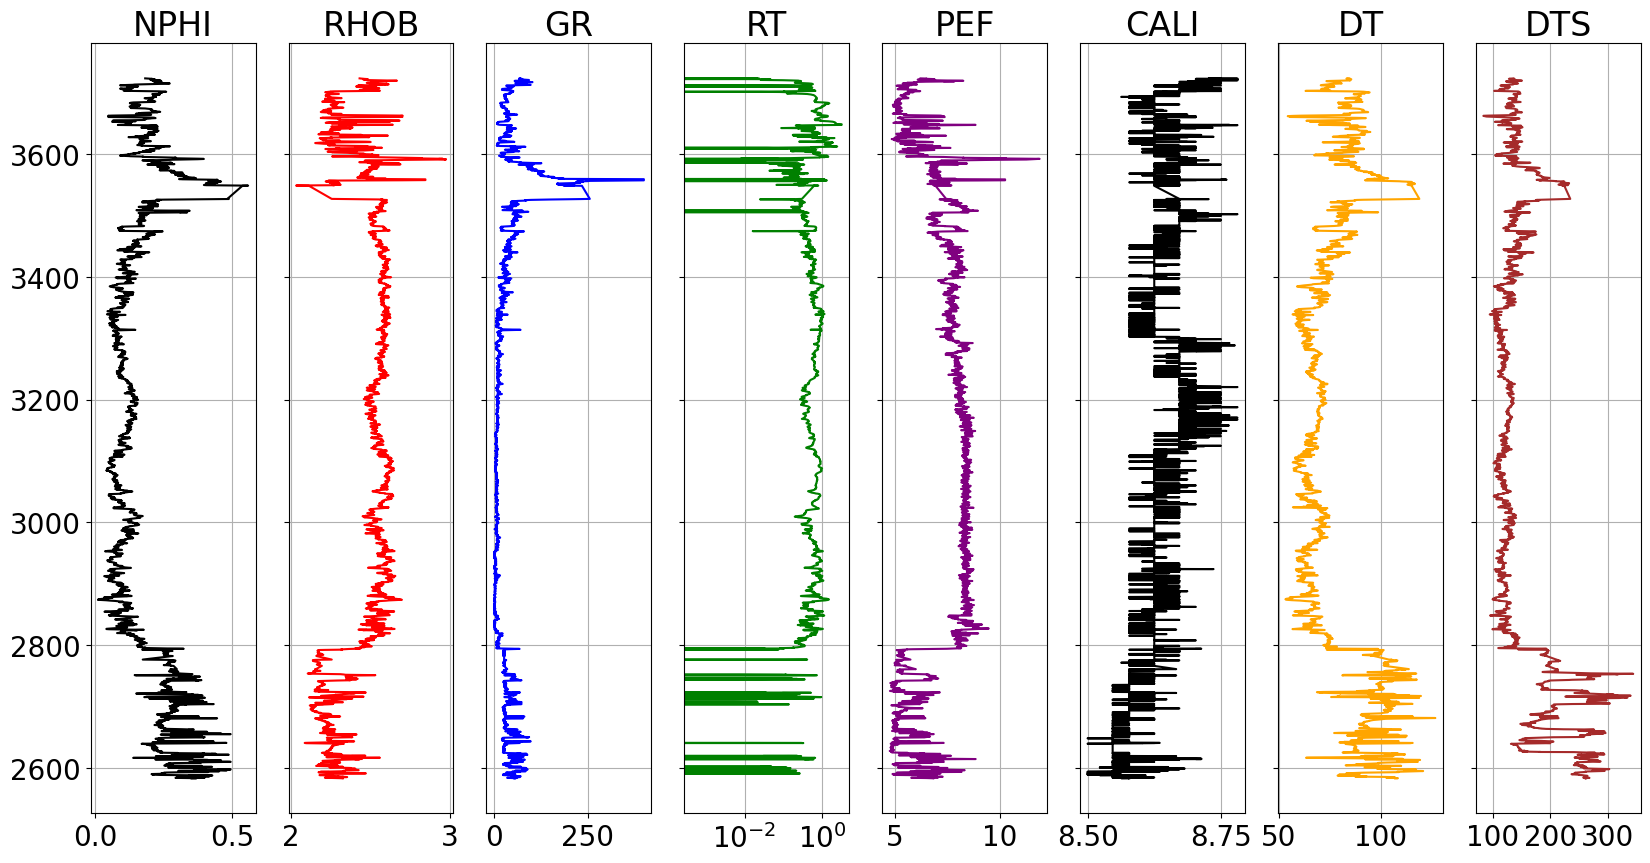

In [17]:
# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange','brown']
well_log_plot(wells[0],logs,colors)

### Step 3. Exploratory Data Analysis (EDA)

It is extremely important to analyze & understand the data at hand before we run any models, or make any assumptions.<br>
EDA helps us identify errors, missing data, outliers, and find interesting relationships between the features.

#### Pairplot

* A Pairplot allows us to analyse pairwise relationships between variables within a dataset. 
* This provides greater insight into the data by summarising a large amount of data in a single figure. 

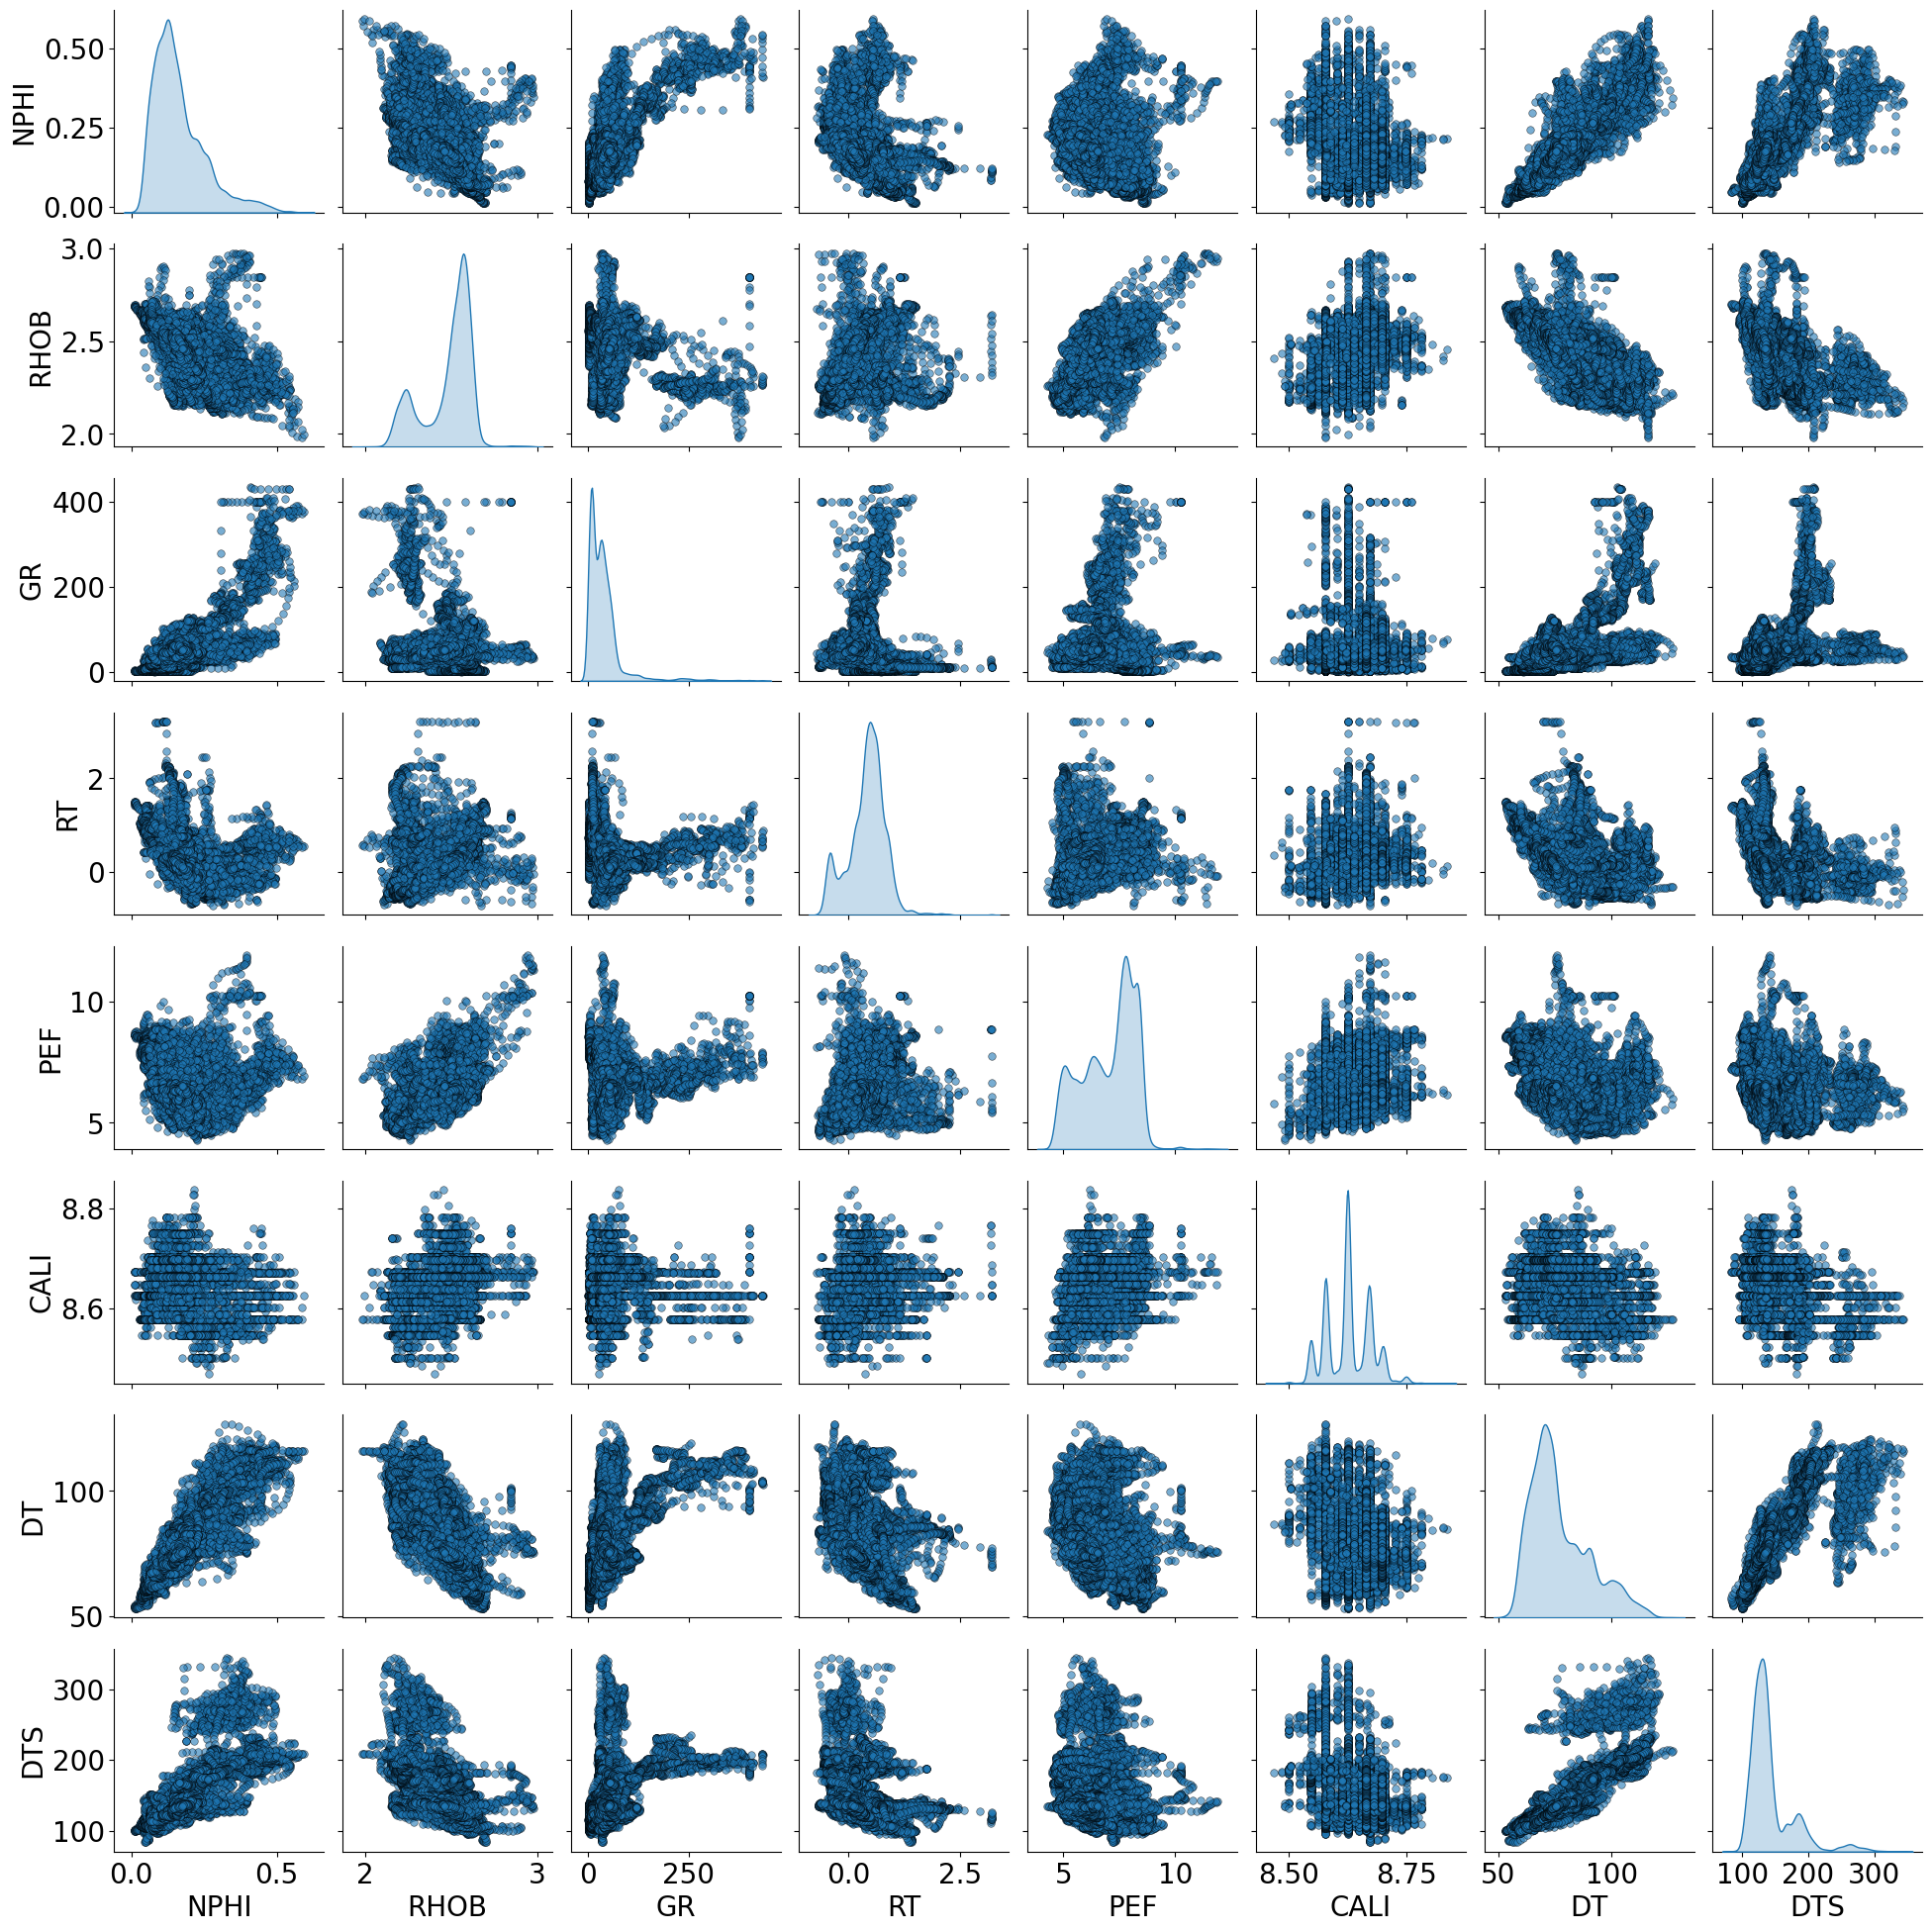

In [18]:
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
sns.pairplot(well_train, vars=train_features, diag_kind='kde', plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

#### Spearman's correlation heatmap

*   Two variables are said to be positively correlated if one increases and the other increases too. In contrast, they are negatively correlated if the high values of one variable go with the low values of another variable.

<Axes: >

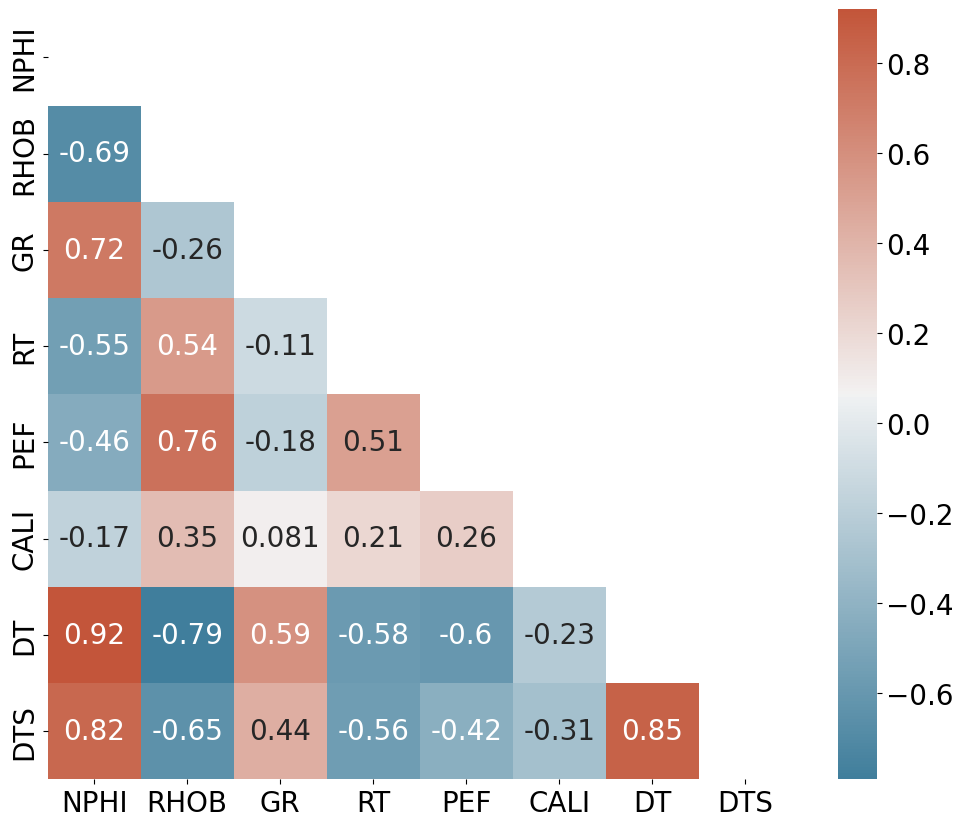

In [19]:
well_train_only_features = well_train[train_features]

# Correlation between different variables

corr = well_train_only_features.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

### Step 4. Normalization

*   Normalization is a transformation of features to bring them to a similar scale. This improves the performance of training, and makes the model more stable.

*   An important thing to remember is that if features have been normalised for the training data, the same normalization steps need to be applied on the test set.

*   Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data.

*   We shall use min-max scaling to constrain the range of the input and output. This would constrain the values between 0 & 1.<br> There are other normalization methods as well such as mean normalization (or standardization) etc.

*   Min-max scaling
        x_scaled = (x — x_min) / (x_max — x_min), where
        x_min → minimum value of a column<br>
        x_max → maximum value of a column

In [20]:
# Importing relevant libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [21]:
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = ['DT','DTS'] # only target column names

#scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

x=well_train[only_feature].copy()
y=well_train[only_target].copy()

# Creating scaled training set
X_train = scaler_X.fit_transform(x.values)
y_train = scaler_y.fit_transform(y.values)

X_test=well_test[only_feature].copy()
y_test=well_test[only_target].copy()

# Creating scaled test set
X_test = scaler_X.transform(X_test.values)
y_test = scaler_y.transform(y_test.values)

In [22]:
# Define the test data 
def well_x_y_normalisation(wells_df=None,
                           well_name:str=None):
  
  # split the dataframe with respect to its name
  test = wells_df.loc[wells_df['WELL'] == well_name]

  # Drop well name column, since it is not a feature
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  X_test_ = scaler_X.transform(X_test_)
  y_test_ = scaler_y.transform(y_test_)
  
  return X_test_,y_test_



In [23]:
wells_df = pd.concat([well_train,well_test],axis=0)

X_test1,y_test1=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[0])
X_test2,y_test2=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[1])
X_test3,y_test3=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[2])
X_test4,y_test4=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[3])

# **Step 5. Shallow learning Training Models**

In [24]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.6 MB/s eta 0:00:00


In [25]:
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LinearRegression, LassoLarsCV, BayesianRidge, SGDClassifier, SGDRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, accuracy_score,mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings("ignore")


### AutoML

In [26]:
class AutoML:
    def __init__(self):
        self.reg_models = [LassoLarsCV(),  LinearRegression(),  DecisionTreeRegressor(),  KNeighborsRegressor(),  
                          SGDRegressor(),  RandomForestRegressor(n_jobs=-1),  AdaBoostRegressor(),  ExtraTreesRegressor(n_jobs=-1),  
                          XGBRegressor(n_jobs=-1),  LGBMRegressor(n_jobs=-1),  CatBoostRegressor(verbose=0),  
                          GradientBoostingRegressor(),  
                          BayesianRidge() ]

    def cross_val(self, X, y, model, metric, folds):
        scores = []
        for tr_in, val_in in KFold(n_splits = folds).split(X, y):
            model_fold = MultiOutputRegressor(model)
            X_train, y_train, X_val, y_val = X.iloc[tr_in,:], y.iloc[tr_in], X.iloc[val_in,:], y.iloc[val_in]
            model_fold.fit(X_train, y_train)
            y_hat = model_fold.predict(X_val)
            scores.append(metric(y_val,y_hat))

        return np.mean(scores)
  
    
    def AutoRegressor(self, X, y, metric = r2_score,folds = 5):
        '''
        X: Independent variable(s)
        y: Dependent variable
        metric: metric of evaluation 
        folds: Number of validation folds, default: 5
        '''
        result = pd.DataFrame(columns = ['Models','Scores'])
        for i,model in enumerate(self.reg_models):
            name = str(model.__class__.__name__)
            scores = self.cross_val(X, y, model, metric, folds)
            
            print('{} got score of {} in {} folds'.format(model.__class__.__name__,scores,folds))
            result.at[i, 'Models'] = name
            result.at[i, 'Scores'] = scores
        result = result.sort_values('Scores').reset_index(drop=True)
        return result

In [27]:
auto_ml = AutoML()
model_result =auto_ml.AutoRegressor(pd.DataFrame(X_train), pd.DataFrame(y_train), metric = r2_score, folds = 5)
model_result

LassoLarsCV got score of 0.6504221809493822 in 5 folds
LinearRegression got score of 0.6493459386253205 in 5 folds
DecisionTreeRegressor got score of 0.22560420295749087 in 5 folds
KNeighborsRegressor got score of 0.6070336305662382 in 5 folds
SGDRegressor got score of 0.6561398225514217 in 5 folds
RandomForestRegressor got score of 0.6305175152007194 in 5 folds
AdaBoostRegressor got score of 0.20383213812387707 in 5 folds
ExtraTreesRegressor got score of 0.6597405855646995 in 5 folds
XGBRegressor got score of 0.6089638170309859 in 5 folds
LGBMRegressor got score of 0.6665968450266565 in 5 folds
CatBoostRegressor got score of 0.6437066602434312 in 5 folds
GradientBoostingRegressor got score of 0.7098890213524751 in 5 folds
BayesianRidge got score of 0.6493393861241507 in 5 folds


Models Scores
0           AdaBoostRegressor  0.204
1       DecisionTreeRegressor  0.226
2         KNeighborsRegressor  0.607
3                XGBRegressor  0.609
4       RandomForestRegressor  0.631
5           CatBoostRegressor  0.644
6               BayesianRidge  0.649
7            LinearRegression  0.649
8                 LassoLarsCV  0.650
9                SGDRegressor  0.656
10        ExtraTreesRegressor  0.660
11              LGBMRegressor  0.667
12  GradientBoostingRegressor  0.710

In [28]:
model = GradientBoostingRegressor()
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

# **Hyperparameters optimisation**

*   Hyperparameters are points of choice or configuration that allow a machine learning model to be customized for a specific task or dataset.

*   Hyperparameter: Model configuration argument specified by the developer to guide the learning process for a specific dataset.
*   Machine learning models also have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.

*   Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

###GridSearchCV Shallow learning 

*  Need to set up a grid of possible combinations of hyperparameters. 
*  scikit-learn will try every combination to fit the model and compute the model's performance with the specified scoring method and the specified cross-validation splitter.

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
## Hyperparameters
param_grid = {'estimator__learning_rate': [0.1,  0.5, 0.9],
 'estimator__loss': ['ls', 'lad', 'huber'],
 'estimator__n_estimators': [10,  500, 1000],
 'estimator__criterion': ['friedman_mse', 'mse'],
 'estimator__min_samples_split': [2, 6, 10],
 'estimator__max_depth': [10, 50,100],
 'estimator__min_samples_leaf': [1,  5, 10],
 'estimator__min_impurity_decrease': [0,  0.4, 0.8],
 'estimator__max_leaf_nodes': [5,  100, 300]}

gb = GradientBoostingRegressor()
gs = GridSearchCV(MultiOutputRegressor(gb), param_grid=param_grid)
#gs.fit(X_train, y_train)

## print best model
#gs.best_params_

In [31]:
#GradientBoostingRegressor()
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

### Bayesian optimization algorithm Shallow learning 

*  https://optuna.readthedocs.io/en/stable/index.html

*  Optuna's algorithmn will decide whether if the combination of hyperparameter is worth training on after a few iterations, and stops the learning process of that combination of hyperparameters if there's limited improvement
*  This optimization increase the speed of your hyper parameter tuning process.

*  To work with Optuna you have to follow the following guideline:

*  Make a objective function, this function will return the value wish to optimize. in our case it will be the MSE loss.
create a study using optuna.create_study(direction='minimize'), will use direction=minimize because we wish to minimize the loss which is MSE.
*  Finally enjoy looking at optuna optimizing your loss!!
*  Thats is it, optuna makes it so simple to optimize the parameters.

In [41]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import optuna 

In [50]:
from sklearn.metrics import r2_score, mean_squared_error 
def model_prediction(X_test=None,y_test=None,model=None):
  # Predict 
  y_pred = model.predict(X_test)
  print("R-squared of Well : {}".format(r2_score(y_pred, y_test)))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print("RMSE of Well : {}".format(rmse))
  return y_pred

In [51]:
def objective(trial):

    param = {'learning_rate':trial.suggest_categorical('learning_rate',[0.1,  0.5, 0.9]),
             'n_estimators':trial.suggest_categorical('n_estimators',[10,  500, 1000]),
             'min_samples_split':trial.suggest_categorical('min_samples_split',[2, 6, 10]),
             'max_depth':trial.suggest_categorical('max_depth',[10, 50,100]),
             'min_samples_leaf':trial.suggest_categorical('min_samples_leaf',[1,  5, 10]),
             'min_impurity_decrease':trial.suggest_categorical('min_impurity_decrease',[0,  0.4, 0.8]),
             'max_leaf_nodes':trial.suggest_categorical('max_leaf_nodes',[5,  100, 300])}
    model = GradientBoostingRegressor(**param)
    model = MultiOutputRegressor(model)
    model.fit(X_train, y_train)
    # Compute estimations:
    y_pred =model_prediction(X_test=X_test,y_test=y_test,model=model)
    y_pred = model.predict(X_test)
    score=r2_score(y_pred, y_test)
    return score


In [52]:
study_name = "sonic_pred" 
study = optuna.create_study(direction="maximize", study_name=study_name)
study.optimize(objective, n_trials=10)

[I 2023-04-03 11:49:47,043] A new study created in memory with name: sonic_pred
[I 2023-04-03 11:50:33,330] Trial 0 finished with value: 0.8539042496184664 and parameters: {'learning_rate': 0.9, 'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0, 'max_leaf_nodes': 5}. Best is trial 0 with value: 0.8539042496184664.


R-squared of Well : 0.8539042496184664
RMSE of Well : 0.05850288863986693


[I 2023-04-03 11:50:35,265] Trial 1 finished with value: 0.3532092866214618 and parameters: {'learning_rate': 0.1, 'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.8, 'max_leaf_nodes': 300}. Best is trial 0 with value: 0.8539042496184664.


R-squared of Well : 0.3532092866214618
RMSE of Well : 0.07702251621259693


[I 2023-04-03 11:50:36,339] Trial 2 finished with value: 0.8185475845615833 and parameters: {'learning_rate': 0.5, 'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 50, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.8, 'max_leaf_nodes': 5}. Best is trial 0 with value: 0.8539042496184664.


R-squared of Well : 0.8185475845615833
RMSE of Well : 0.056188916564296226


[I 2023-04-03 11:50:37,782] Trial 3 finished with value: 0.8552107338800954 and parameters: {'learning_rate': 0.9, 'n_estimators': 10, 'min_samples_split': 6, 'max_depth': 100, 'min_samples_leaf': 10, 'min_impurity_decrease': 0, 'max_leaf_nodes': 5}. Best is trial 3 with value: 0.8552107338800954.


R-squared of Well : 0.8552107338800954
RMSE of Well : 0.05559763392051898


[I 2023-04-03 11:52:13,519] Trial 4 finished with value: 0.8657514254512525 and parameters: {'learning_rate': 0.5, 'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 100, 'min_samples_leaf': 5, 'min_impurity_decrease': 0, 'max_leaf_nodes': 5}. Best is trial 4 with value: 0.8657514254512525.


R-squared of Well : 0.8657514254512525
RMSE of Well : 0.05584620989463313


[I 2023-04-03 11:52:32,479] Trial 5 finished with value: 0.867205553684788 and parameters: {'learning_rate': 0.5, 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 100, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.4, 'max_leaf_nodes': 300}. Best is trial 5 with value: 0.867205553684788.


R-squared of Well : 0.867205553684788
RMSE of Well : 0.051981476165524336


[I 2023-04-03 11:52:50,587] Trial 6 finished with value: 0.8594329045485583 and parameters: {'learning_rate': 0.9, 'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.8, 'max_leaf_nodes': 300}. Best is trial 5 with value: 0.867205553684788.


R-squared of Well : 0.8594329045485583
RMSE of Well : 0.05481560396120911


[I 2023-04-03 11:53:09,509] Trial 7 finished with value: 0.8687352131690593 and parameters: {'learning_rate': 0.9, 'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.4, 'max_leaf_nodes': 300}. Best is trial 7 with value: 0.8687352131690593.


R-squared of Well : 0.8687352131690593
RMSE of Well : 0.054135959188233176


[I 2023-04-03 11:53:47,896] Trial 8 finished with value: 0.8646166526403027 and parameters: {'learning_rate': 0.1, 'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 50, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.4, 'max_leaf_nodes': 100}. Best is trial 7 with value: 0.8687352131690593.


R-squared of Well : 0.8646166526403027
RMSE of Well : 0.051025706452954574


[I 2023-04-03 11:54:25,503] Trial 9 finished with value: 0.8608476502578846 and parameters: {'learning_rate': 0.9, 'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 100, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.4, 'max_leaf_nodes': 300}. Best is trial 7 with value: 0.8687352131690593.


R-squared of Well : 0.8608476502578846
RMSE of Well : 0.05468691541681158


In [53]:
# Print the best parameters
print('Best parameters', study.best_params)

Best parameters {'learning_rate': 0.9, 'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.4, 'max_leaf_nodes': 300}


In [54]:
model = GradientBoostingRegressor(learning_rate= 0.9, n_estimators= 500, min_samples_split= 6, max_depth= 10, min_samples_leaf= 10, min_impurity_decrease= 0.4, max_leaf_nodes= 300)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.9,
                                                         max_depth=10,
                                                         max_leaf_nodes=300,
                                                         min_impurity_decrease=0.4,
                                                         min_samples_leaf=10,
                                                         min_samples_split=6,
                                                         n_estimators=500))

# **Step 6: Predictions**

In [63]:
from sklearn.metrics import r2_score, mean_squared_error 
def model_prediction(X_test=None,y_test=None,model=None):
  # Predict 
  y_pred = model.predict(X_test)
  print("R-squared of Well : {}".format(r2_score(y_pred, y_test)))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print("RMSE of Well : {}".format(rmse))
  return y_pred

y_pred1 =model_prediction(X_test=X_test1,y_test=y_test1,model=model)
y_pred2 =model_prediction(X_test=X_test2,y_test=y_test2,model=model)
y_pred3 =model_prediction(X_test=X_test3,y_test=y_test3,model=model)
y_pred4 =model_prediction(X_test=X_test4,y_test=y_test4,model=model)

R-squared of Well : 0.8853448750209156
RMSE of Well : 0.05560255745868333
R-squared of Well : 0.9006104713877598
RMSE of Well : 0.04117260529355631
R-squared of Well : 0.6409416948071258
RMSE of Well : 0.047435232255643
R-squared of Well : 0.8687352131690593
RMSE of Well : 0.054135959188233176


### Step 7: check_predictions 

In [64]:
# Compute estimations:
y_pred =model_prediction(X_test=X_test,y_test=y_test,model=model)
#denormalisation
y_true = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(y_pred)

R-squared of Well : 0.8687352131690593
RMSE of Well : 0.054135959188233176


In [65]:
def qc_cross_plot(y_true=None,y_pred=None):
  # Plot results:
  plt.figure(figsize=(15,5))
  i = 0
  plt.subplot(1,2,i+1)
  plt.plot(y_true[:,i], y_pred[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_pred[:,i], y_true[:,i])))
  plt.plot([y_pred[:,i].min(),y_pred[:,i].max()],[y_pred[:,i].min(),y_pred[:,i].max()], 'r', label = '1:1 line')
  plt.title('#1 DTC: y_pred vs. y_estimate ')
  plt.xlabel('True')
  plt.ylabel('Estimate')
  plt.legend()
  i += 1
  plt.subplot(1,2,i+1)
  plt.plot(y_true[:,i], y_pred[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_pred[:,i], y_true[:,i])))
  plt.plot([y_pred[:,i].min(),y_pred[:,i].max()],[y_pred[:,i].min(),y_pred[:,i].max()], 'r', label = '1:1 line')
  plt.title('#2 DTS: y_pred vs. y_estimate')
  plt.xlabel('True')
  plt.ylabel('Estimate')
  plt.legend()
  plt.show()

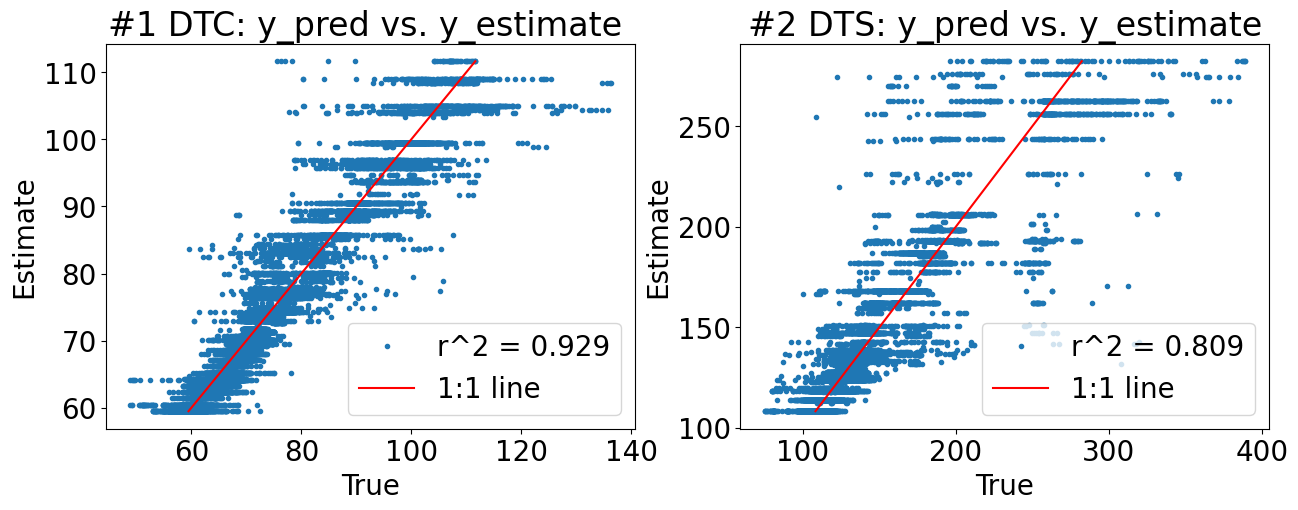

In [66]:
qc_cross_plot(y_true=y_true,y_pred=y_pred)

In [67]:
def qc_errors(y_true=None,y_pred=None):
  MSE_0 = mean_squared_error(y_true[:,0], y_pred[:,0]);
  RMSE_0 = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]));
  MSE_1 = mean_squared_error(y_true[:,1], y_pred[:,1]);
  RMSE_1 = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]));
  print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
  print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
  print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

In [68]:
qc_errors(y_true=y_true,y_pred=y_pred)

RMSE of test data (#1 DTC): 3.55
RMSE of test data (#2 DTS): 15.50
Overall RMSE = 11.24


In [69]:
def qc_prediction_curve_plot(y_true=None,y_pred=None,well_test=None):
  well_test['DT_predicted']=y_pred[:,0]
  well_test['DTS_predicted']=y_pred[:,1]
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,20))
  i = 0
  ax[i].plot(well_test['DT'],well_test['DEPTH'],label='True')
  ax[i].plot(well_test['DT_predicted'],well_test['DEPTH'],linewidth=2,label='Predicted')
  ax[i].set_ylabel('Depth')
  ax[i].set_xlabel('DTC')
  ax[i].invert_yaxis()
  ax[i].set_title('DTC Prediction')
  ax[i].grid(True)
  i += 1
  ax[i].plot(well_test['DTS'],well_test['DEPTH'],label='True')
  ax[i].plot(well_test['DTS_predicted'],well_test['DEPTH'],linewidth=2,label='Predicted')
  ax[i].legend()
  ax[i].set_ylabel('Depth')
  ax[i].set_xlabel('DTS')
  ax[i].invert_yaxis()
  ax[i].set_title('DTS Prediction ')
  ax[i].grid(True)
  plt.show()

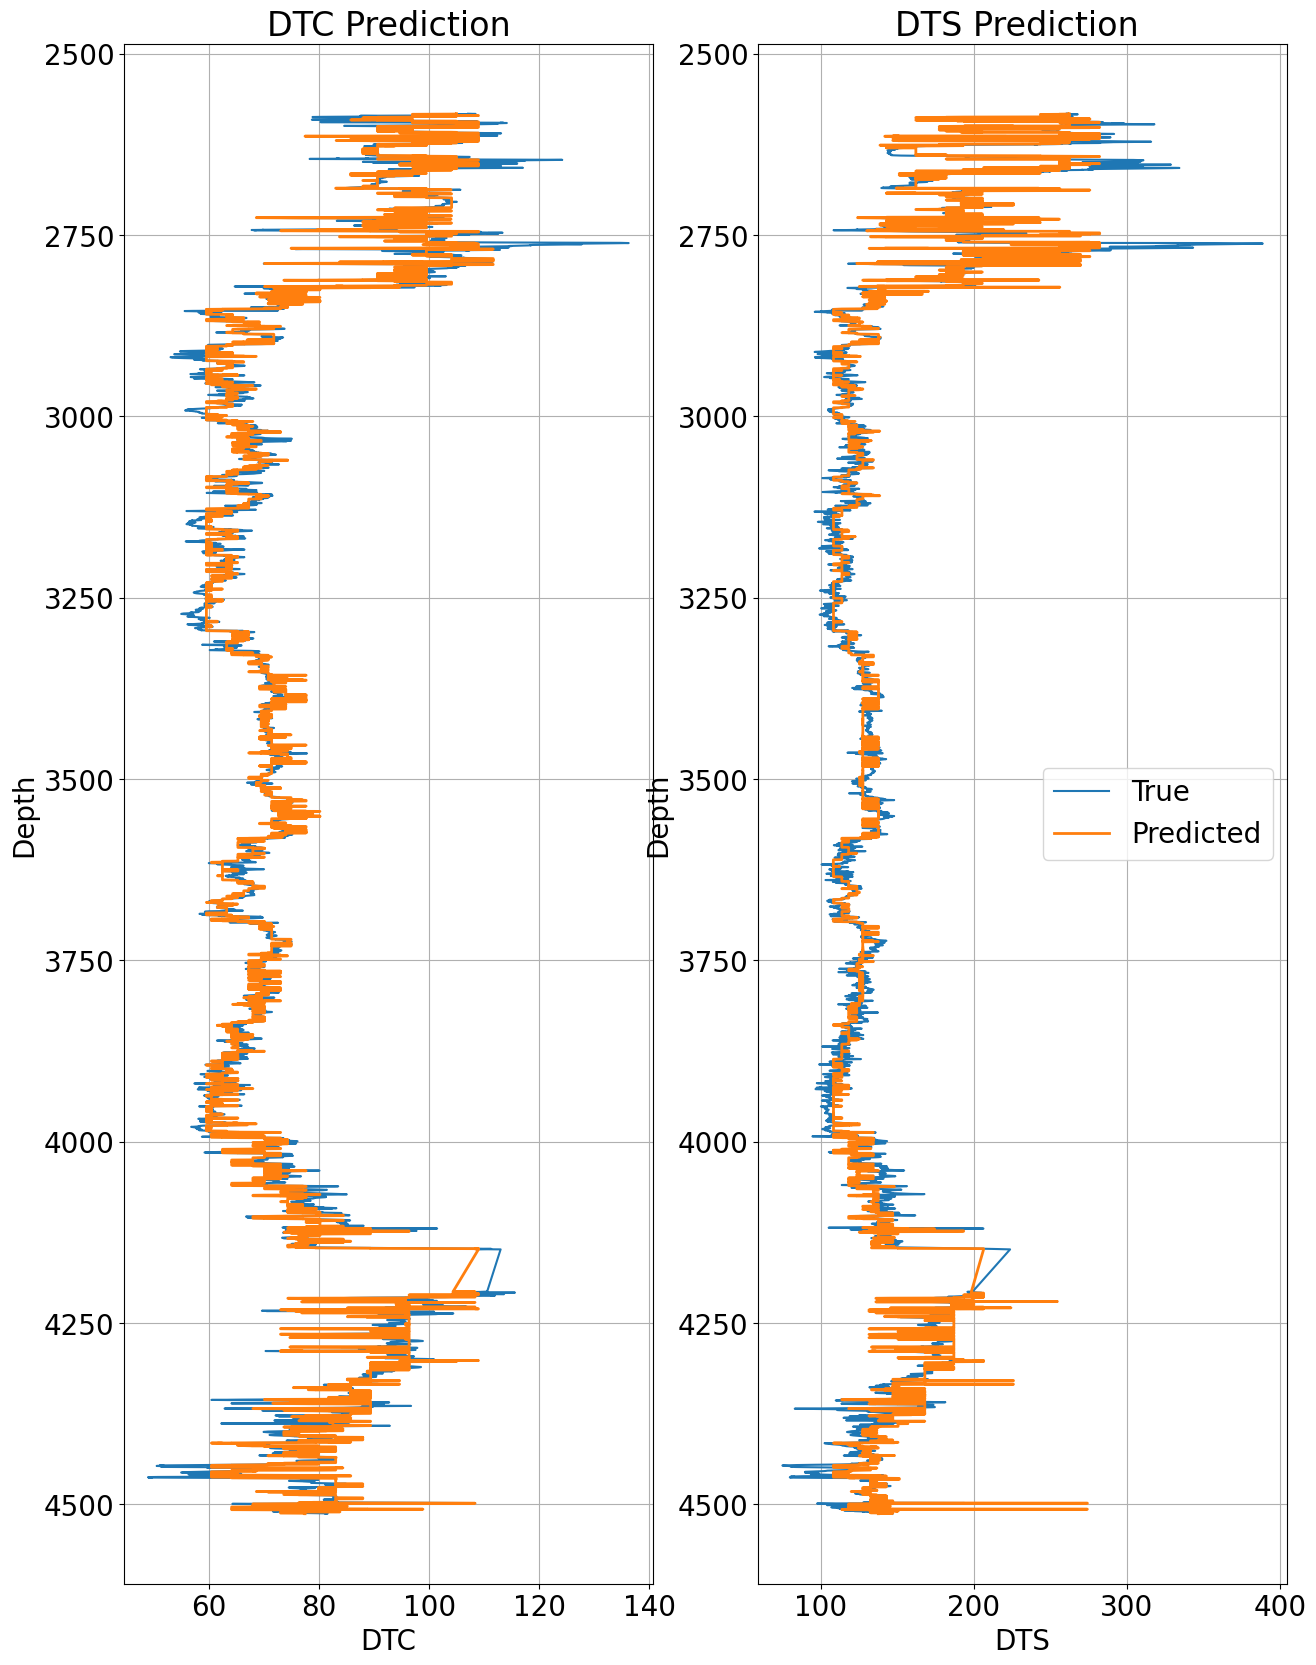

In [70]:
qc_prediction_curve_plot(y_true=y_true,y_pred=y_pred,well_test=well_test)

* can be tried for more trials to get better results

# **Conclusions**

* The predicted logs bear a close resemblance to the true sonic logs.
* Different ML algorithms can be applied on the data. Some may perform better than others, depending on the parameters used, the abundance of data available, etc.
